# Feature Importance with Captum

In [1]:
import torch
from importlib import import_module

WORKSPACE_DIR = 'C:/Users/User/projects/msc-thesis-recurrent-health-modeling/'
print(f"Workspace directory: {WORKSPACE_DIR}")

# ---- User inputs (EDIT ME) ----
DATASET_TEST_PT_PATH = f"{WORKSPACE_DIR}_models/mimic/deep_learning/attention_pooling/multiple_hosp_patients/test_dataset.pt"  # path to test .pt file
DATASET_TRAIN_PT_PATH = f"{WORKSPACE_DIR}_models/mimic/deep_learning/attention_pooling/multiple_hosp_patients/train_full_dataset.pt"  # path to train .pt file
MODEL_MODULE = "recurrent_health_events_prediction.model.RecurrentHealthEventsDL"
MODEL_CLASS_NAME = "AttentionPoolingNet"   # e.g., GRUNet, AttentionPoolingNet, CrossAttnPoolingNet
CONFIG_PATH = f"{WORKSPACE_DIR}_runs/attention_pooling_20251020_143800/model_config.yaml" # path to model config yaml

Workspace directory: C:/Users/User/projects/msc-thesis-recurrent-health-modeling/


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load datasets and model

In [6]:
if CONFIG_PATH is not None:
    import yaml
    with open(CONFIG_PATH, "r") as f:
        model_cfg = yaml.safe_load(f)
    MODEL_CLASS_NAME = model_cfg.get("model_class", MODEL_CLASS_NAME)
    MODEL_PARAMS = model_cfg.get("model_params")
    print("Loaded config:", CONFIG_PATH)
else:
    print("Using inline MODEL_PARAMS.")
print("Model class:", MODEL_CLASS_NAME)
print("Model params:", MODEL_PARAMS)


Loaded config: C:/Users/User/projects/msc-thesis-recurrent-health-modeling/_runs/attention_pooling_20251020_143800/model_config.yaml
Model class: AttentionPoolingNet
Model params: {'dropout': 0.05732217549155437, 'hidden_size_head': 64, 'hidden_size_seq': 8, 'input_size_curr': 19, 'input_size_seq': 8}


In [7]:
test_dataset_obj = torch.load(DATASET_TEST_PT_PATH, weights_only=False)
train_dataset_obj = torch.load(DATASET_TRAIN_PT_PATH, weights_only=False)
print(f"Loaded dataset_object type: {type(test_dataset_obj)}")

# Try to build a batch (x_current, x_past, mask_past, labels) in a few common cases
def extract_batch(dataset_obj, model_config):
    """Return a tuple (x_current, x_past, mask_past, labels).
    Supports a Dataset, a tuple of tensors, or a dict.
    """
    if hasattr(dataset_obj, '__getitem__') and hasattr(dataset_obj, '__len__'):
        # Looks like a Dataset
        sample = dataset_obj[0]
        if isinstance(sample, (list, tuple)) and len(sample) >= 4:
            loader = torch.utils.data.DataLoader(dataset_obj, batch_size=model_config["batch_size"], shuffle=False)
            batch = next(iter(loader))
            return batch  # expect (x_current, x_past, mask_past, labels)
        else:
            raise ValueError("Dataset sample does not look like (x_current, x_past, mask_past, labels)")
    elif isinstance(dataset_obj, (list, tuple)):
        if len(dataset_obj) >= 4:
            return tuple(t if torch.is_tensor(t) else torch.tensor(t) for t in obj[:4])
        else:
            raise ValueError("Tuple does not have 4 elements")
    elif isinstance(dataset_obj, dict):
        # Common keys
        keys = ["x_current", "x_past", "mask_past", "labels"]
        if all(k in dataset_obj for k in keys):
            return tuple(dataset_obj[k] if torch.is_tensor(dataset_obj[k]) else torch.tensor(dataset_obj[k]) for k in keys)
        else:
            raise ValueError("Dict missing one of required keys: x_current, x_past, mask_past, labels")
    else:
        raise TypeError("Unsupported .pt content; please save a Dataset, dict, or tuple of tensors.")


Loaded dataset_object type: <class 'recurrent_health_events_prediction.datasets.HospReadmDataset.HospReadmDataset'>


In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset_obj, batch_size=model_cfg["batch_size"], shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset_obj, batch_size=model_cfg["batch_size"], shuffle=False
)

In [10]:
# Import model class and instantiate
mod = import_module(MODEL_MODULE)
ModelClass = getattr(mod, MODEL_CLASS_NAME)
model = ModelClass(**MODEL_PARAMS).eval()  # eval mode for graph drawing
print(model.__class__.__name__, "initialized.")


AttentionPoolingNet initialized.


## Helpers Captum

In [20]:
def make_baselines(x_curr, x_past, mask, strategy="zeros"):
    if strategy == "zeros":
        base_curr = torch.zeros_like(x_curr)
        base_past = torch.zeros_like(x_past)
    else:
        raise NotImplementedError
    base_past[~mask.unsqueeze(-1).expand_as(base_past)] = 0.0
    return base_curr, base_past


def forward_for_attr(model, x_curr, x_past, mask):
    out = model(x_current=x_curr, x_past=x_past, mask_past=mask)
    if isinstance(out, tuple):
        logits, _ = out
    else:
        logits = out
    return logits


## Feature Importance with Captum

In [24]:
@torch.no_grad()
def global_feature_importance(model, loader, device, n_steps=32):
    ig = IntegratedGradients(
        lambda x_c, x_p, m: forward_for_attr(model, x_c, x_p, m)
    )

    sum_abs_curr = None
    sum_abs_past_feat = None
    sum_abs_time = None
    n = 0

    for x_curr, x_past, mask, y in loader:
        x_curr = x_curr.to(device).requires_grad_(True)
        x_past = x_past.to(device).requires_grad_(True)
        mask = mask.to(device)
        if mask.dim() == 3 and mask.shape[-1] == 1:
            mask = mask.squeeze(-1)

        base_curr, base_past = make_baselines(x_curr, x_past, mask)

        attr_curr, attr_past = ig.attribute(
            inputs=(x_curr, x_past),
            baselines=(base_curr, base_past),
            additional_forward_args=(mask,),
            target=None,
            n_steps=n_steps
        )

        # |abs| e agregações
        b_curr = attr_curr.abs().sum(dim=0)           # [D_curr]
        b_past_feat = attr_past.abs().sum(dim=(0,1))  # [D_long]
        b_time = attr_past.abs().sum(dim=(0,2))       # [T]

        if sum_abs_curr is None:
            sum_abs_curr, sum_abs_past_feat, sum_abs_time = b_curr, b_past_feat, b_time
        else:
            sum_abs_curr += b_curr
            sum_abs_past_feat += b_past_feat
            sum_abs_time += b_time

        n += x_curr.size(0)

    mean_curr = sum_abs_curr / n
    mean_past_feat = sum_abs_past_feat / n
    mean_time = sum_abs_time / n

    return mean_curr, mean_past_feat, mean_time

In [22]:
from captum.attr import IntegratedGradients

def compute_batch_attributions(model, loader, device, n_steps=32):
    model.eval()
    ig = IntegratedGradients(lambda x_c, x_p, mask: model(x_c, x_p, mask)[0])  # [0] to unpack logits
    all_attr_curr = []
    all_attr_past = []
    
    for x_curr, x_past, mask, *_ in loader:
        x_curr = x_curr.to(device).requires_grad_(True)
        x_past = x_past.to(device).requires_grad_(True)
        mask = mask.to(device)

        base_curr = torch.zeros_like(x_curr)
        base_past = torch.zeros_like(x_past)
        
        attr_curr, attr_past = ig.attribute(
            inputs=(x_curr, x_past),
            baselines=(base_curr, base_past),
            additional_forward_args=(mask,),
            n_steps=n_steps,
        )
        all_attr_curr.append(attr_curr.detach().cpu())
        all_attr_past.append(attr_past.detach().cpu())

    return torch.cat(all_attr_curr), torch.cat(all_attr_past)

Top features (x_curr):
 1. Feature 11 | Importance: 0.0717
 2. Feature 4 | Importance: 0.0394
 3. Feature 0 | Importance: 0.0386
 4. Feature 5 | Importance: 0.0274
 5. Feature 2 | Importance: 0.0248
 6. Feature 1 | Importance: 0.0203
 7. Feature 6 | Importance: 0.0195
 8. Feature 3 | Importance: 0.0181
 9. Feature 9 | Importance: 0.0154
10. Feature 14 | Importance: 0.0131

Top features (x_past):
 1. Feature 4 | Importance: 0.0252
 2. Feature 2 | Importance: 0.0182
 3. Feature 0 | Importance: 0.0159
 4. Feature 3 | Importance: 0.0101
 5. Feature 1 | Importance: 0.0079


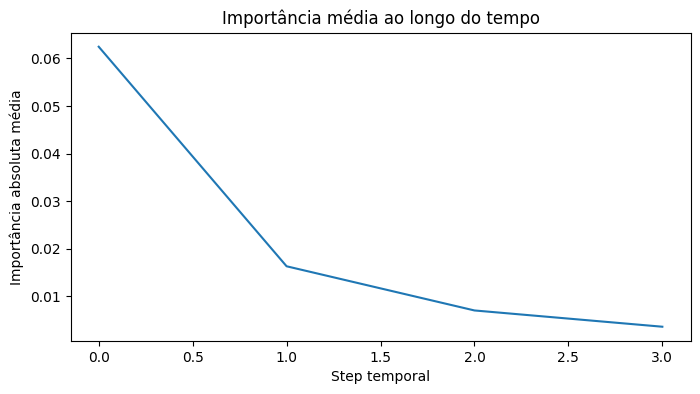

In [26]:
from matplotlib import pyplot as plt

mean_curr, mean_past_feat, mean_time = global_feature_importance(
    model, test_loader, device
)

# Top-k features atuais
k = 10
top_vals, top_idx = torch.topk(mean_curr, k)
print("Top features (x_curr):")
for i, (v, idx) in enumerate(zip(top_vals, top_idx)):
    print(f"{i+1:2d}. Feature {idx.item()} | Importance: {v.item():.4f}")

k = 5
# Top-k features históricas
top_vals_p, top_idx_p = torch.topk(mean_past_feat, k)
print("\nTop features (x_past):")
for i, (v, idx) in enumerate(zip(top_vals_p, top_idx_p)):
    print(f"{i+1:2d}. Feature {idx.item()} | Importance: {v.item():.4f}")

# Importância por tempo
plt.figure(figsize=(8,4))
plt.plot(mean_time.cpu())
plt.title("Importância média ao longo do tempo")
plt.xlabel("Step temporal")
plt.ylabel("Importância absoluta média")
plt.show()
